## Optimization dynamics predicted by spectrum-matched Gaussian

<a href="https://colab.research.google.com/github/diffscore/diffscore/blob/master/examples/matched-gaussian-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook shows an example of replacing the neural dataset by a Gaussian dataset with the same spectrum. Suprisingly, the resulting optimization dynamics are very similar to the original neural dataset.

Install requirements (if not already installed):

In [ ]:
!git clone https://github.com/diffscore/diffscore.git
%cd diffscore
!pip install -e .

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

import diffscore

In [2]:
# choose a dataset (here we choose a synthetic dataset for speed)
dataset = "ultrametric"
# dataset = "Mante2013"  # example of neural dataset

# load the dataset (this might take a while for neural datasets)
X, conditions = diffscore.Dataset(dataset)

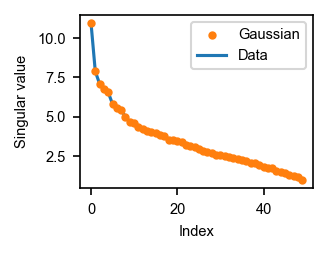

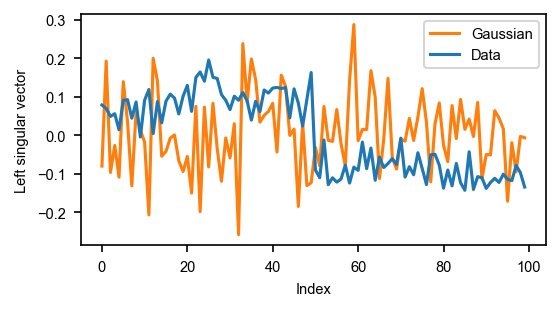

In [3]:
# preprocessing
if X.ndim == 3:
    # reshape from (time, trial, neuron) to (time * trial, neuron)
    _X = X.reshape(X.shape[0] * X.shape[1], X.shape[2])
else:
    _X = X
# center the data
_X -= _X.mean(axis=0)
# compute the singular value decomposition of the data
U, S, V = np.linalg.svd(_X, full_matrices=False)

# create a gaussian dataset with the same singular values
Y = np.random.randn(*_X.shape)
U_Y, S_Y, Vt_Y = np.linalg.svd(Y, full_matrices=False)
X_gaussian = U_Y @ np.diag(S) @ Vt_Y

# plot the singular values
plt.figure(figsize=(2, 1.5), dpi=150)
plt.scatter(range(len(S)), np.linalg.svd(X_gaussian, full_matrices=False)[1], label="Gaussian", marker=".", color="tab:orange")
plt.plot(S, label="Data", zorder=-1)
plt.xlabel("Index")
plt.ylabel("Singular value")
plt.legend()
plt.show()

# plot the first left singular vector to make sure they are different
plt.figure(figsize=(4, 2), dpi=150)
plt.plot(np.linalg.svd(X_gaussian, full_matrices=False)[0][:, 0], label="Gaussian", color="tab:orange")
plt.plot(U[:, 0], label="Data", color="tab:blue")
plt.xlabel("Index")
plt.ylabel("Left singular vector")
plt.legend()
plt.show()

In [4]:
# choose a similarity measure 
measure = "cka"
# measure = "procrustes-angular-score"
max_iter = 100

# optimize similarity between a randomly initialized dataset and the neural dataset
res = diffscore.optimize(dataset=X, measure=measure, max_iter=max_iter)

Iter 0, score: 0.25695367105393924
Iter 10, score: 0.8948642415950143
Iter 20, score: 0.9550088798315056
Iter 30, score: 0.9767248752072364
Iter 40, score: 0.9870862677614664
Iter 50, score: 0.9918782178428596
Iter 60, score: 0.9945914843544272
Iter 70, score: 0.9961791544250203
Iter 80, score: 0.9972308916639517
Iter 90, score: 0.9979800160805907
Final score 0.9984719531394902


In [5]:
# same but with the neural dataset replaced by the gaussian dataset
res_gaussian = diffscore.optimize(dataset=X_gaussian, measure=measure, max_iter=max_iter)

Iter 0, score: 0.2609136000105769
Iter 10, score: 0.9081680737113496
Iter 20, score: 0.9619980972499647
Iter 30, score: 0.9811157223181405
Iter 40, score: 0.9896392671457005
Iter 50, score: 0.9939326320767758
Iter 60, score: 0.9959904910631294
Iter 70, score: 0.9972949334804575
Iter 80, score: 0.9980961723922511
Iter 90, score: 0.998650940182105
Final score 0.999007051990513


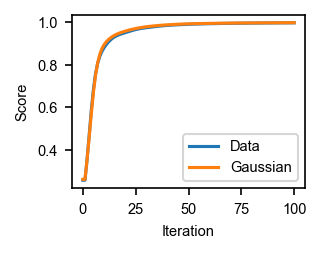

In [6]:
plt.figure(figsize=(2, 1.5), dpi=150)
plt.plot(res.scores, label="Data")
plt.plot(res_gaussian.scores, label="Gaussian")
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.legend()
plt.show()

We can analyze the optimization dynamics by computing the similarity scores required to capture each principal component of the original dataset.

In [13]:
pc_res = diffscore.analyze_pc(res)
pc_res_gaussian = diffscore.analyze_pc(res_gaussian)
plt.close('all')

We can see in the figure below that the curve for the Gaussian dataset closely matches the curve for the neural dataset.

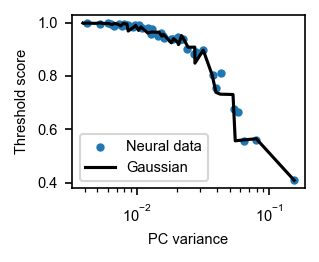

In [14]:
plt.figure(figsize=(2, 1.5), dpi=150)
plt.scatter(pc_res.pc_variance, pc_res.threshold_scores, marker=".", label="Neural data")
plt.plot(pc_res_gaussian.pc_variance, pc_res_gaussian.threshold_scores, color="black", label="Gaussian")
plt.xlabel("PC variance")
plt.ylabel("Threshold score")
plt.xscale("log")
plt.legend()
plt.show()

Let's repeat the analysis for several measures.

In [25]:
max_iter = 100
measures = [
    "cka",
    "nbs",
    "procrustes-angular-score",
    "ridge-lambda100-r2",
    "ridge-lambda100-r2#5folds_cv",
]

results = {}
results_gaussian = {}
for measure in measures:
    print(f"Measure: {measure}")

    res = diffscore.optimize(dataset=X, measure=measure, max_iter=max_iter)
    res_gaussian = diffscore.optimize(dataset=X, measure=measure, max_iter=max_iter)

    pc_res = diffscore.analyze_pc(res)
    pc_res_gaussian = diffscore.analyze_pc(res_gaussian)

    results[measure] = pc_res
    results_gaussian[measure] = pc_res_gaussian
    plt.close('all')

Measure: cka
Iter 0, score: 0.2348730173281312
Iter 10, score: 0.8959852540625184
Iter 20, score: 0.9565546082524293
Iter 30, score: 0.9773938867228941
Iter 40, score: 0.9868692743405477
Iter 50, score: 0.9920253951855674
Iter 60, score: 0.9949109800393979
Iter 70, score: 0.9966000877734618
Iter 80, score: 0.9976251550897326
Iter 90, score: 0.9982919618374808
Final score 0.9987084524064503
Iter 0, score: 0.26032521426036775
Iter 10, score: 0.9017334364709649
Iter 20, score: 0.9583780644294672
Iter 30, score: 0.9772437478438005
Iter 40, score: 0.986876609216241
Iter 50, score: 0.9919159987336168
Iter 60, score: 0.9947023642378039
Iter 70, score: 0.9963866388818513
Iter 80, score: 0.9974316072030043
Iter 90, score: 0.9981072861786844
Final score 0.9985215149975787
Measure: nbs
Iter 0, score: 0.5389489328038707
Iter 10, score: 0.9320166786988475
Iter 20, score: 0.9895142266857548
Iter 30, score: 0.9959642113882171
Iter 40, score: 0.9984163285800585
Iter 50, score: 0.9994478546205344
Iter 

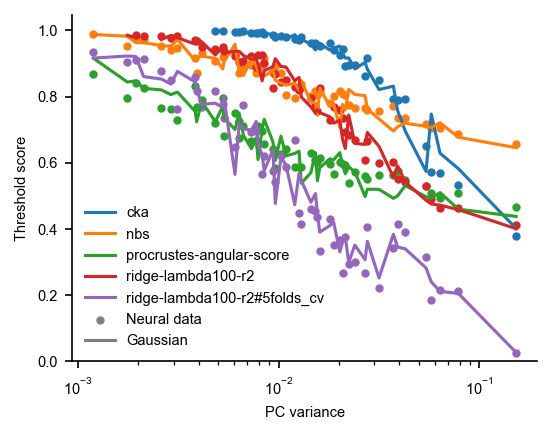

In [26]:
plt.figure(figsize=(4, 3), dpi=150)
for measure in measures:
    pc_res = results[measure]
    pc_res_gaussian = results_gaussian[measure]

    plt.scatter(pc_res.pc_variance, pc_res.threshold_scores, marker=".")
    plt.plot(pc_res_gaussian.pc_variance, pc_res_gaussian.threshold_scores, label=measure)

plt.scatter([], [], marker=".", label="Neural data", color="gray")
plt.plot([], [], label="Gaussian", color="gray")
plt.xlabel("PC variance")
plt.ylabel("Threshold score")
plt.xscale("log")
plt.ylim(0, None)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False)
plt.show()